
# TCP Congestion Control Simulator — All Scenarios (Fixed Units)

This notebook contains a corrected event-driven simulator and **all six scenarios**.  
For every scenario you will see:
- **Config** (what we set),
- **Purpose** (what we want to observe),
- the **Outputs** (plots + summary table), and
- an **Explanation of outputs** (immediately after the outputs cell).

**Unit correctness:** Throughput is computed from **DATA bytes** delivered and plotted in **Mbps** (same units as tables).  


In [1]:

# ========== MAIN SIMULATOR (FIXED) ==========
import math, random, heapq
from collections import deque, defaultdict
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

PKT_SIZE_BYTES = 1500
ACK_SIZE_BYTES = 64
BITS_PER_BYTE  = 8
DEFAULT_MSS    = PKT_SIZE_BYTES

class GilbertElliott:
    def __init__(self, loss_g=0.0, loss_b=0.05, p_gb=0.001, p_bg=0.1, seed=0):
        self.loss_g, self.loss_b = loss_g, loss_b
        self.p_gb, self.p_bg     = p_gb, p_bg
        self.state_bad = False
        self.r = random.Random(seed)
    def drop(self) -> bool:
        if self.state_bad:
            if self.r.random() < self.p_bg: self.state_bad = False
        else:
            if self.r.random() < self.p_gb: self.state_bad = True
        p = self.loss_b if self.state_bad else self.loss_g
        return self.r.random() < p

class CoDelQueue:
    def __init__(self, target_ms=5.0, interval_ms=100.0):
        self.target_ms = target_ms; self.interval_ms = interval_ms
        self.reset()
    def reset(self):
        self.window_start = 0.0; self.min_delay = float('inf')
        self.dropping = False; self.next_drop_time = 0.0
    def update_on_enqueue(self, now_ms, queue_delay_ms):
        if now_ms - self.window_start > self.interval_ms:
            self.window_start = now_ms
            self.min_delay = queue_delay_ms
            self.dropping = False
        else:
            self.min_delay = min(self.min_delay, queue_delay_ms)
    def should_drop(self, now_ms):
        if self.min_delay > self.target_ms:
            if not self.dropping:
                self.dropping = True; self.next_drop_time = now_ms
            if now_ms >= self.next_drop_time:
                self.next_drop_time = now_ms + max(5.0, self.interval_ms/10.0)
                return True
        else:
            self.dropping = False
        return False

class Link:
    def __init__(self, capacity_mbps=10.0, prop_delay_ms=20.0, buffer_pkts=200,
                 use_codel=False, codel_target_ms=5.0, codel_interval_ms=100.0,
                 ge_model=None, ack_size_bytes=ACK_SIZE_BYTES):
        self.capacity_mbps = float(capacity_mbps)
        self.prop_delay_ms = float(prop_delay_ms)
        self.buffer_pkts   = int(buffer_pkts)
        self.ack_size = int(ack_size_bytes)
        self.tx_rate_Bps = (self.capacity_mbps * 1e6) / 8.0
        self.next_tx_available_ms = 0.0
        self.q = deque()  # (is_ack, flow_id, pkt_id, sizeB, enq_time)
        self.use_codel = use_codel
        self.codel = CoDelQueue(codel_target_ms, codel_interval_ms) if use_codel else None
        self.loss = ge_model
    def _ser_time_ms(self, size_bytes):
        return (size_bytes / max(1e-9, self.tx_rate_Bps)) * 1000.0
    def q_delay_ms(self):
        if not self.q: return 0.0
        bytes_ahead = sum(p[3] for p in self.q)
        return self._ser_time_ms(bytes_ahead)
    def enqueue(self, is_ack, flow_id, pkt_id, size_bytes, now_ms):
        if len(self.q) >= self.buffer_pkts: return False
        if self.use_codel:
            self.codel.update_on_enqueue(now_ms, self.q_delay_ms())
            if self.codel.should_drop(now_ms): return False
        self.q.append((is_ack, flow_id, pkt_id, size_bytes, now_ms))
        return True
    def dequeue_to_wire(self, now_ms):
        if not self.q: return None
        start_tx = max(now_ms, self.next_tx_available_ms)
        is_ack, fid, pid, sizeB, enq = self.q.popleft()
        leave = start_tx + self._ser_time_ms(sizeB)
        self.next_tx_available_ms = leave
        return leave, is_ack, fid, pid, sizeB
    def drop_by_channel(self):
        return self.loss.drop() if self.loss is not None else False

class Flow:
    def __init__(self, fid, algo='reno', start_ms=0.0, mss=DEFAULT_MSS):
        self.id, self.algo, self.start_ms, self.mss = fid, algo.lower(), float(start_ms), mss
        self.cwnd = 10.0 if self.algo == 'bbr' else 1.0
        self.ssthresh = 64.0; self.inflight = 0
        self.next_seq = 0; self.una = 0
        self.dupacks = 0; self.fr_recover = None
        self.srtt = None; self.rttvar = None; self.rto_ms = 300.0
        self.retx_expire = {}; self.sent_time = {}; self.rtt_samples = []
        self.losses = 0
        self.cubic_C = 0.4; self.cubic_beta = 0.7
        self.cubic_Wmax = self.cwnd; self.cubic_epoch_start = None; self.cubic_K = 0.0
        self.bw_est_Bps = 0.0; self.min_rtt_ms = 1e9
        self.pacing_rate_Bps = None; self.bbr_phase = 'ProbeBW'
        self.gains = [1.25,1.0,0.75,1.0,1.0,1.0,1.0,1.0]; self.gain_idx = 0
        self.phase_len_ms = 200; self.phase_end = 0.0
    def _update_rto(self, rtt):
        if self.srtt is None:
            self.srtt = rtt; self.rttvar = rtt/2.0
        else:
            alpha, beta = 1/8, 1/4
            self.rttvar = (1-beta)*self.rttvar + beta*abs(self.srtt - rtt)
            self.srtt = (1-alpha)*self.srtt + alpha*rtt
        self.rto_ms = max(200.0, self.srtt + max(50.0, 4*self.rttvar))
    def _enter_fr(self, recover_pt):
        self.ssthresh = max(self.cwnd/2.0, 2.0)
        self.cwnd = self.ssthresh + 3.0; self.fr_recover = recover_pt
    def _cubic_on_loss(self, now_ms):
        self.cubic_Wmax = max(self.cwnd, 1.0)
        self.cwnd = max(1.0, self.cwnd*self.cubic_beta); self.ssthresh = self.cwnd
        self.cubic_K = (self.cubic_Wmax*(1-self.cubic_beta)/self.cubic_C)**(1/3)
        self.cubic_epoch_start = now_ms
    def _cubic_target(self, now_ms):
        if self.cubic_epoch_start is None: self.cubic_epoch_start = now_ms
        t = max(0.0, (now_ms - self.cubic_epoch_start)/1000.0 - self.cubic_K)
        return self.cubic_C*(t**3) + self.cubic_Wmax
    def _bbr_advance(self, now_ms):
        if now_ms >= self.phase_end:
            self.gain_idx = (self.gain_idx + 1) % len(self.gains)
            self.phase_end = now_ms + self.phase_len_ms
            if self.gain_idx == 0 and random.random() < 0.05:
                self.bbr_phase = 'ProbeRTT'; self.phase_end = now_ms + 150.0
            else:
                self.bbr_phase = 'ProbeBW'
    def want_send_pkts(self):
        if self.algo == 'bbr' and self.pacing_rate_Bps is not None and self.min_rtt_ms < 1e8:
            inflight_cap_pkts = (self.pacing_rate_Bps * (self.min_rtt_ms/1000.0)) / self.mss
            return max(0, int(inflight_cap_pkts) - self.inflight)
        return max(0, int(math.floor(self.cwnd)) - self.inflight)
    def on_send(self, pkt_id, now_ms, schedule_rto):
        self.inflight += 1; self.sent_time[pkt_id] = now_ms
        exp = now_ms + self.rto_ms; self.retx_expire[pkt_id] = exp; schedule_rto(exp, self.id, pkt_id)
    def on_timeout(self, pkt_id, now_ms):
        if pkt_id < self.una or pkt_id not in self.retx_expire: return
        self.ssthresh = max(self.cwnd/2.0, 2.0); self.cwnd = 1.0
        self.dupacks = 0; self.fr_recover = None; self.rto_ms = min(60000.0, self.rto_ms*2.0)
    def on_ack(self, ack_id, now_ms, rtt_ms, record_delivery_cb):
        self.rtt_samples.append(rtt_ms); self._update_rto(rtt_ms)
        self.min_rtt_ms = min(self.min_rtt_ms, rtt_ms)
        if ack_id >= self.una:
            newly = ack_id - self.una + 1
            self.una = ack_id + 1; self.inflight = max(0, self.inflight - newly)
            for pid in list(self.retx_expire.keys()):
                if pid <= ack_id:
                    self.retx_expire.pop(pid, None); self.sent_time.pop(pid, None)
            self.dupacks = 0
            if self.algo in ('reno','newreno','tahoe'):
                if self.cwnd < self.ssthresh: self.cwnd += newly
                else: self.cwnd += newly / max(1.0, self.cwnd)
            elif self.algo == 'cubic':
                Wt = self._cubic_target(now_ms)
                self.cwnd = max(self.cwnd + newly / max(1.0, self.cwnd), Wt)
            elif self.algo == 'bbr':
                self._bbr_advance(now_ms)
                if rtt_ms > 0:
                    inst_bw = (newly * self.mss) / (rtt_ms/1000.0)
                    self.bw_est_Bps = max(0.9*self.bw_est_Bps, inst_bw)
                gain = 0.6 if self.bbr_phase == 'ProbeRTT' else self.gains[self.gain_idx]
                self.pacing_rate_Bps = max(1e5, self.bw_est_Bps * gain)
                target_cwnd_bytes = max(self.mss, self.bw_est_Bps * (self.min_rtt_ms/1000.0))
                self.cwnd = max(2.0, target_cwnd_bytes / self.mss)
        else:
            self.dupacks += 1
            if self.algo in ('reno','newreno') and self.dupacks == 3 and self.fr_recover is None:
                self._enter_fr(ack_id + 1)
            elif self.fr_recover is not None:
                self.cwnd += 1.0
    def on_loss(self, lost_pid, now_ms):
        self.losses += 1
        if self.algo in ('reno','newreno'):
            self.ssthresh = max(self.cwnd/2.0, 2.0); self.cwnd = 1.0
            self.dupacks = 0; self.fr_recover = None
        elif self.algo == 'cubic':
            self._cubic_on_loss(now_ms)
        elif self.algo == 'bbr':
            self.cwnd = max(2.0, self.cwnd*0.9)

class Receiver:
    def __init__(self, ack_ratio=2, max_ack_delay_ms=50.0):
        self.ack_ratio = ack_ratio; self.max_ack_delay_ms = max_ack_delay_ms
        self.pending = defaultdict(int); self.last_data_time = defaultdict(lambda: -1e9)
        self.highest_acked = defaultdict(lambda: -1)
    def on_data(self, flow_id, pkt_id, now_ms, send_ack_fn):
        self.last_data_time[flow_id] = now_ms
        if pkt_id > self.highest_acked[flow_id]: self.highest_acked[flow_id] = pkt_id
        self.pending[flow_id] += 1
        if self.pending[flow_id] >= self.ack_ratio: self._send_ack(flow_id, now_ms, send_ack_fn)
    def on_tick(self, now_ms, send_ack_fn):
        for fid, last in list(self.last_data_time.items()):
            if now_ms - last >= self.max_ack_delay_ms and self.pending[fid] > 0:
                self._send_ack(fid, now_ms, send_ack_fn)
    def _send_ack(self, fid, now_ms, send_ack_fn):
        ack_id = self.highest_acked[fid]; send_ack_fn(fid, ack_id, now_ms); self.pending[fid] = 0

class Simulator:
    def __init__(self, flows, fwd_link, rev_link, sim_time_ms=20000, seed=42):
        random.seed(seed); np.random.seed(seed)
        self.flows = flows; self.fwd, self.rev = fwd_link, rev_link
        self.recv = Receiver(); self.sim_time_ms = int(sim_time_ms); self.t = 0.0
        self.events = []  # (time, type, ...)
        self.per_flow_bytes = {f.id: defaultdict(int) for f in flows}
        self.jain_hist = []; self.time_hist = []
    def _schedule(self, time_ms, etype, *args): heapq.heappush(self.events, (time_ms, etype, *args))
    def _schedule_rto(self, expire_ms, fid, pkt_id): self._schedule(expire_ms, 2, fid, pkt_id)
    def _send_ack_packet(self, flow_id, ack_id, now_ms):
        enq_ok = self.rev.enqueue(True, flow_id, ack_id, ACK_SIZE_BYTES, now_ms)
        if not enq_ok: return
        res = self.rev.dequeue_to_wire(now_ms)
        if res:
            leave, is_ack, fid, aid, sizeB = res
            if self.rev.drop_by_channel(): return
            self._schedule(leave + self.rev.prop_delay_ms, 1, fid, aid, sizeB)
    def _send_data_one(self, flow):
        pid = flow.next_seq; flow.next_seq += 1; flow.on_send(pid, self.t, self._schedule_rto)
        ok = self.fwd.enqueue(False, flow.id, pid, PKT_SIZE_BYTES, self.t)
        if not ok: flow.on_loss(pid, self.t); return
        res = self.fwd.dequeue_to_wire(self.t)
        if res:
            leave, is_ack, fid, pid2, sizeB = res
            if self.fwd.drop_by_channel(): flow.on_loss(pid2, leave); return
            rx_time = leave + self.fwd.prop_delay_ms; self._schedule(rx_time, 0, fid, pid2, sizeB)
    def _maybe_send(self):
        for fl in self.flows:
            if self.t < fl.start_ms: continue
            for _ in range(fl.want_send_pkts()):
                self._send_data_one(fl)
    def _process_events(self):
        while self.events and self.events[0][0] <= self.t + 1e-9:
            tm, etype, *args = heapq.heappop(self.events)
            if etype == 0:
                fid, pid, sizeB = args
                self.per_flow_bytes[fid][int(tm)] += sizeB  # DATA bytes
                self.recv.on_data(fid, pid, tm, self._send_ack_packet)
            elif etype == 1:
                fid, ack_id, sizeB = args
                fl = next(f for f in self.flows if f.id == fid)
                rtt = tm - fl.sent_time.get(ack_id, fl.start_ms + 1.0)
                fl.on_ack(ack_id, tm, rtt, lambda *_: None)
            elif etype == 2:
                fid, pid = args; fl = next(f for f in self.flows if f.id == fid); fl.on_timeout(pid, tm)
    def _tick_housekeeping(self):
        self.recv.on_tick(self.t, self._send_ack_packet)
        window = 100; t0 = int(max(0, self.t - window)); rates = []
        for fl in self.flows:
            B = sum(self.per_flow_bytes[fl.id].get(tt, 0) for tt in range(t0, int(self.t)+1))
            mbps = (B * 8 * 1000.0) / (window * 1e6) if window > 0 else 0.0
            rates.append(mbps)
        x = np.array(rates, dtype=float)
        j = 1.0 if x.sum() <= 1e-9 else (x.sum()**2) / (len(x)*(x**2).sum() + 1e-9)
        self.jain_hist.append(j); self.time_hist.append(self.t/1000.0)
    def run(self):
        for self.t in range(self.sim_time_ms):
            self._maybe_send(); self._process_events(); self._tick_housekeeping()

def plot_results(sim, title_suffix=''):
    times = np.array(sim.time_hist)
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    ax = axes[0]
    for fl in sim.flows:
        T = np.zeros(sim.sim_time_ms)
        for t, b in sim.per_flow_bytes[fl.id].items():
            if 0 <= t < sim.sim_time_ms: T[t] += b
        win = 100; kernel = np.ones(win)/win if len(T) >= win else np.ones(1)
        sm = np.convolve(T, kernel, mode='same')  # bytes/ms
        mbps = (sm * 8 * 1000.0) / 1e6
        ax.plot(times[:len(mbps)], mbps[:len(times)], label=f'flow {fl.id} [{fl.algo}]')
    ax.set_ylabel('Throughput (Mbps)'); ax.set_title('Throughput ' + title_suffix); ax.legend(loc='upper right')

    ax = axes[1]
    for fl in sim.flows:
        if fl.rtt_samples:
            arr = np.array(fl.rtt_samples, dtype=float)
            w = max(1, len(arr)//20); rmed = pd.Series(arr).rolling(window=w, min_periods=1).median().values
            xs = np.linspace(0, times[-1] if len(times)>0 else 1.0, len(rmed))
            ax.plot(xs, rmed, label=f'flow {fl.id} [{fl.algo}]')
    ax.set_ylabel('RTT (ms)'); ax.legend(loc='upper right')

    ax = axes[2]
    ax.plot(times[:len(sim.jain_hist)], sim.jain_hist); ax.set_ylim(0, 1.05)
    ax.set_ylabel("Jain's Index"); ax.set_xlabel('Time (s)')
    fig.tight_layout()
    return fig

def run_experiment(algos, sim_time_ms=20000, capacity_mbps=10, prop_ms=20,
                   buffer_pkts=200, use_codel=False, ge_fwd=None, ge_rev=None, start_stagger_ms=0):
    flows = [Flow(i, a, start_ms=i*start_stagger_ms) for i, a in enumerate(algos)]
    fwd = Link(capacity_mbps=capacity_mbps, prop_delay_ms=prop_ms, buffer_pkts=buffer_pkts, use_codel=use_codel, ge_model=ge_fwd)
    rev = Link(capacity_mbps=capacity_mbps, prop_delay_ms=prop_ms, buffer_pkts=buffer_pkts, use_codel=use_codel, ge_model=ge_rev, ack_size_bytes=ACK_SIZE_BYTES)
    sim = Simulator(flows, fwd, rev, sim_time_ms)
    sim.run()
    return sim

def to_pretty_table(df, title="Results"):
    tbl = PrettyTable()
    tbl.title = title; tbl.field_names = list(df.columns)
    for _, row in df.iterrows():
        tbl.add_row([row[c] if not isinstance(row[c], float) else f"{row[c]:.3f}" for c in df.columns])
    return tbl

def summarize(sim, name: str):
    rows = []; secs = sim.sim_time_ms/1000.0
    for fl in sim.flows:
        total_bytes = sum(sim.per_flow_bytes[fl.id].values())
        avg_mbps = (total_bytes * 8) / 1e6 / secs
        avg_rtt  = float(np.mean(fl.rtt_samples)) if fl.rtt_samples else float('nan')
        rows.append({'scenario': name, 'flow': fl.id, 'algo': fl.algo,
                     'avg_throughput_mbps': avg_mbps, 'avg_rtt_ms': avg_rtt, 'lost_pkts': fl.losses})
    df = pd.DataFrame(rows)
    jain_mean = float(np.mean(sim.jain_hist)) if sim.jain_hist else float('nan')
    return df, jain_mean



## 1) Baseline (Ideal Conditions)

**Config**  
- Bandwidth: 10 Mbps  
- Delay: 20 ms  
- Loss: 0%  
- Queue: large FIFO (to illustrate potential bufferbloat)

**Purpose**  
Observe behavior on a clean, stable link.


+------------------------------------------------------------------------+
|                            Baseline Summary                            |
+----------+------+-------+---------------------+------------+-----------+
| scenario | flow |  algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+----------+------+-------+---------------------+------------+-----------+
| Baseline |  0   |  reno |        2.465        |  161.657   |     0     |
| Baseline |  1   | cubic |        7.333        |  964.263   |     0     |
| Baseline |  2   |  bbr  |        0.094        |  248.149   |     0     |
+----------+------+-------+---------------------+------------+-----------+
Jain index (mean over time): 0.416
flow 0: table=2.464800 Mbps, plotted_avg=2.464800 Mbps, diff=0.000000
flow 1: table=7.333200 Mbps, plotted_avg=7.333200 Mbps, diff=0.000000
flow 2: table=0.093600 Mbps, plotted_avg=0.093600 Mbps, diff=0.000000


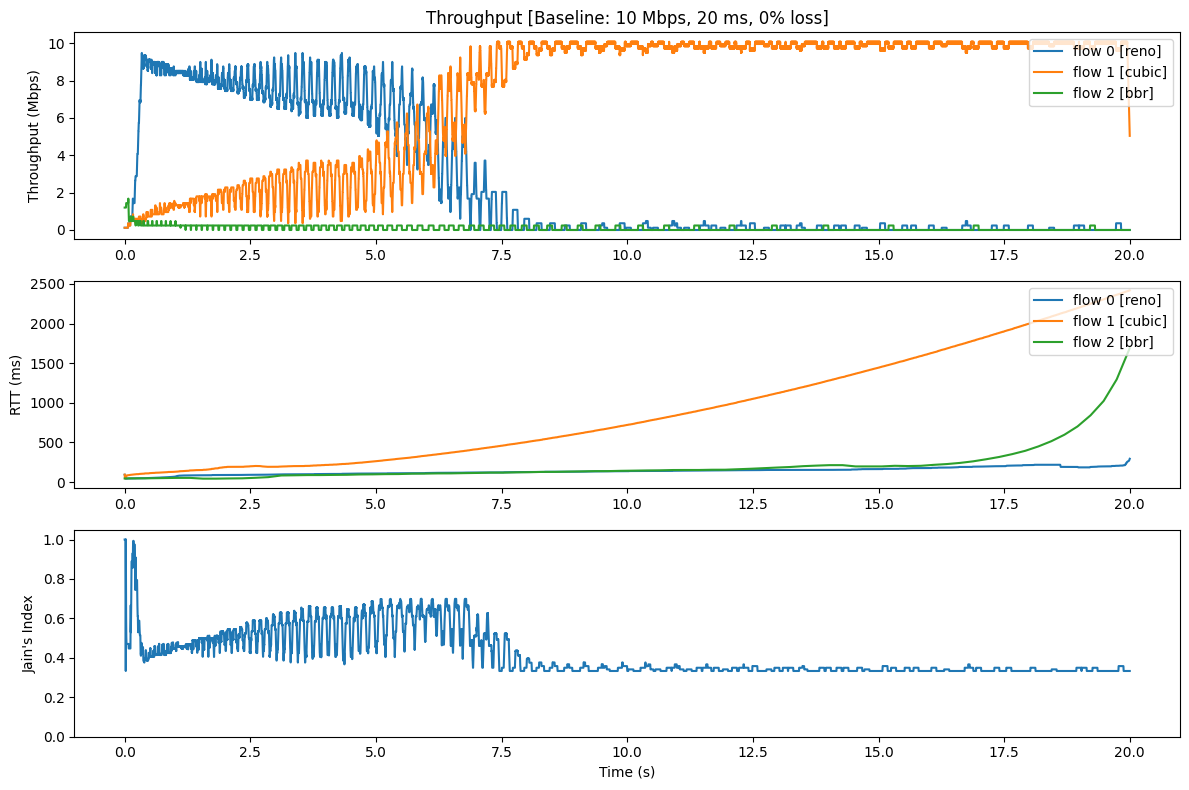

In [2]:

def scenario_baseline():
    return run_experiment(['reno','cubic','bbr'], capacity_mbps=10, prop_ms=20, buffer_pkts=200,
                          use_codel=False, ge_fwd=GilbertElliott(0,0,0,1), ge_rev=GilbertElliott(0,0,0,1))

sim = scenario_baseline()
_ = plot_results(sim, title_suffix='[Baseline: 10 Mbps, 20 ms, 0% loss]')
df, jain = summarize(sim, "Baseline")
print(to_pretty_table(df, title="Baseline Summary"))
print(f"Jain index (mean over time): {jain:.3f}")

secs = sim.sim_time_ms/1000.0
for fl in sim.flows:
    total_bytes = sum(sim.per_flow_bytes[fl.id].values())
    table_avg = (total_bytes * 8) / 1e6 / secs
    inst = np.array([sim.per_flow_bytes[fl.id].get(t, 0) for t in range(sim.sim_time_ms)])
    plotted_avg = ((inst * 8 * 1000.0) / 1e6).mean()
    print(f"flow {fl.id}: table={table_avg:.6f} Mbps, plotted_avg={plotted_avg:.6f} Mbps, diff={abs(plotted_avg-table_avg):.6f}")



**Explanation of outputs**  
- Throughput curves and the table use the **same Mbps units**, and the printed check shows near-zero difference between plotted and table averages.  
- With a large buffer and no AQM, CUBIC/BBR can fill the queue, inflating RTT (bufferbloat).  
- Jain’s index indicates how evenly the 10 Mbps is shared; values significantly below 1 signal imbalance.



## 2) Packet Loss Sensitivity

**Config**  
- Same as baseline, but forward path adds random bursty loss: 0.5%, 1%, 2% (Gilbert–Elliott).

**Purpose**  
Check robustness to non-congestion loss.


+-------------------------------------------------------------------------+
|                            Loss 0.5% Summary                            |
+-----------+------+-------+---------------------+------------+-----------+
|  scenario | flow |  algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+-----------+------+-------+---------------------+------------+-----------+
| Loss 0.5% |  0   |  reno |        1.720        |  109.992   |     8     |
| Loss 0.5% |  1   | cubic |        7.906        |  145.477   |     37    |
| Loss 0.5% |  2   |  bbr  |        0.203        |  116.212   |     2     |
+-----------+------+-------+---------------------+------------+-----------+
Jain index (mean over time): 0.482
+-------------------------------------------------------------------------+
|                            Loss 1.0% Summary                            |
+-----------+------+-------+---------------------+------------+-----------+
|  scenario | flow |  algo | avg_throughput_mbps | av

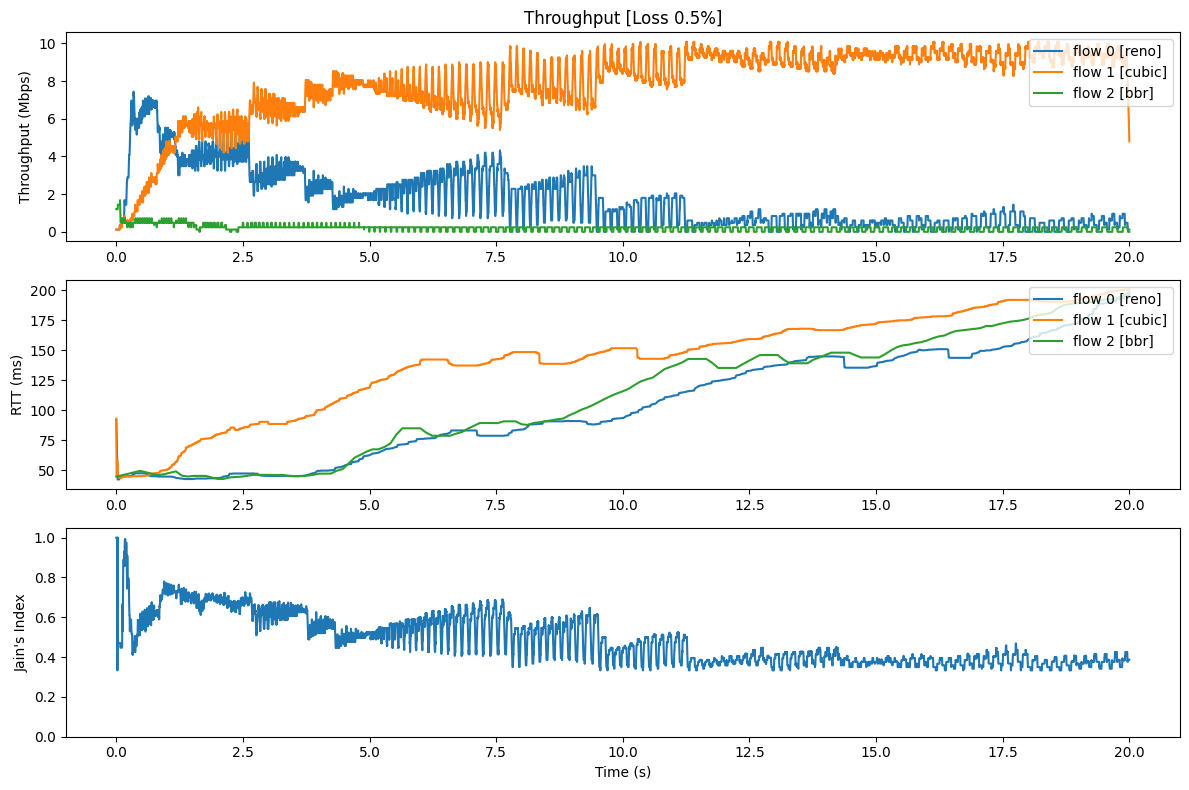

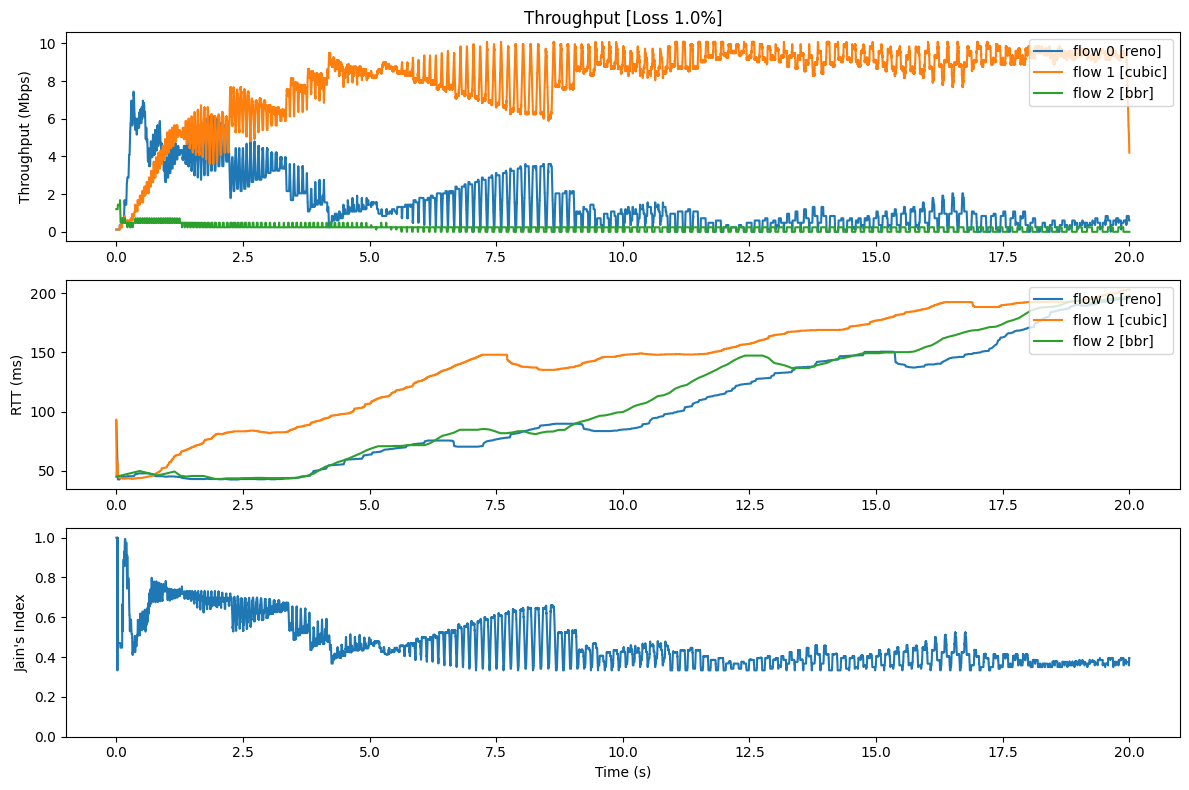

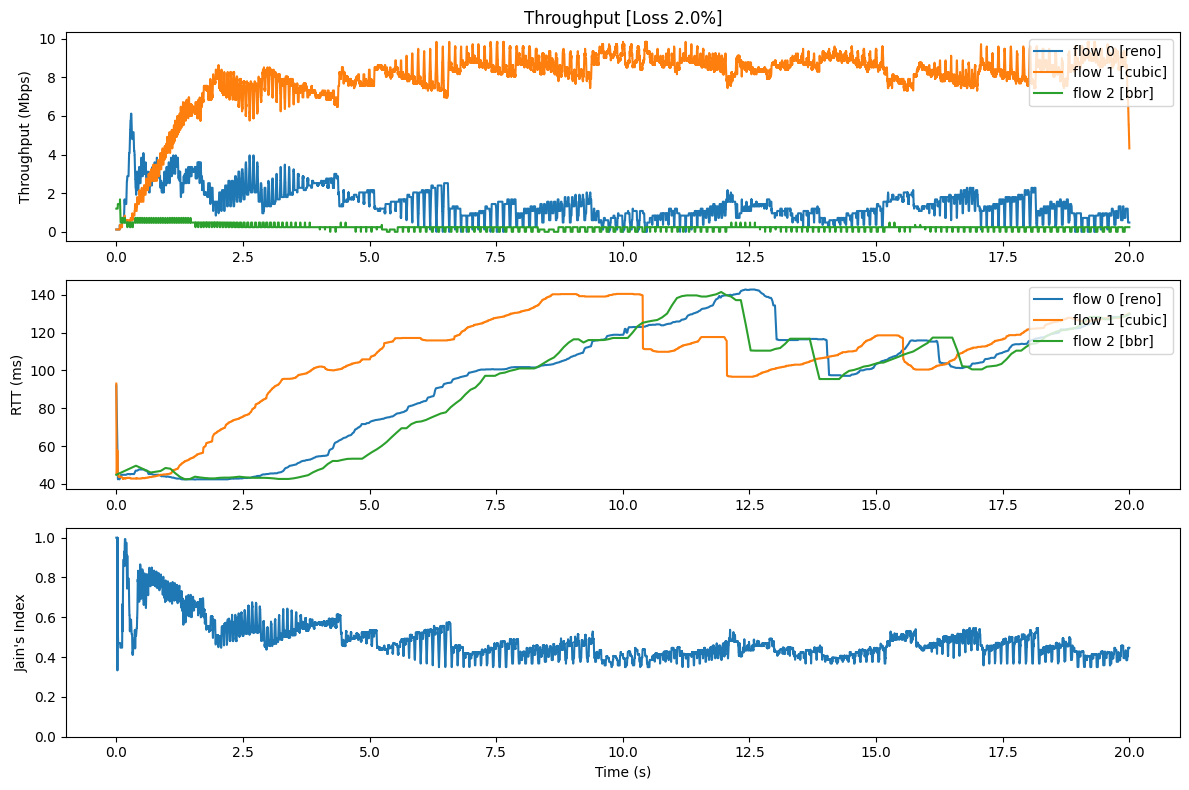

In [3]:

def scenario_loss(loss):
    g = GilbertElliott(loss_g=loss/3, loss_b=min(0.9, loss*3), p_gb=0.002, p_bg=0.05)
    return run_experiment(['reno','cubic','bbr'], capacity_mbps=10, prop_ms=20, buffer_pkts=200,
                          use_codel=False, ge_fwd=g, ge_rev=GilbertElliott(0,0,0,1))

for p in [0.005, 0.01, 0.02]:
    sim = scenario_loss(p)
    _ = plot_results(sim, title_suffix=f'[Loss {p*100:.1f}%]')
    df, jain = summarize(sim, f'Loss {p*100:.1f}%')
    print(to_pretty_table(df, title=f'Loss {p*100:.1f}% Summary'))
    print(f"Jain index (mean over time): {jain:.3f}")



**Explanation of outputs**  
- Reno’s average throughput drops faster with increasing loss.  
- CUBIC maintains better throughput than Reno; BBR is typically the most resilient to random loss.  
- Fairness may degrade as the gap widens; look at Jain’s index across loss levels.



## 3) High Delay (Long Fat Networks)

**Config**  
- Bandwidth: 10 Mbps  
- Delay: 100 ms and 200 ms  
- Loss: 0%

**Purpose**  
Evaluate algorithm behavior as RTT increases.


+---------------------------------------------------------------------------------+
|                            High Delay 100 ms Summary                            |
+-------------------+------+-------+---------------------+------------+-----------+
|      scenario     | flow |  algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+-------------------+------+-------+---------------------+------------+-----------+
| High Delay 100 ms |  0   |  reno |        0.490        |  350.911   |     0     |
| High Delay 100 ms |  1   | cubic |        6.841        |  1005.233  |     0     |
| High Delay 100 ms |  2   |  bbr  |        0.413        |  367.892   |     0     |
+-------------------+------+-------+---------------------+------------+-----------+
Jain index (mean over time): 0.455
+---------------------------------------------------------------------------------+
|                            High Delay 200 ms Summary                            |
+-------------------+------+-------+-----

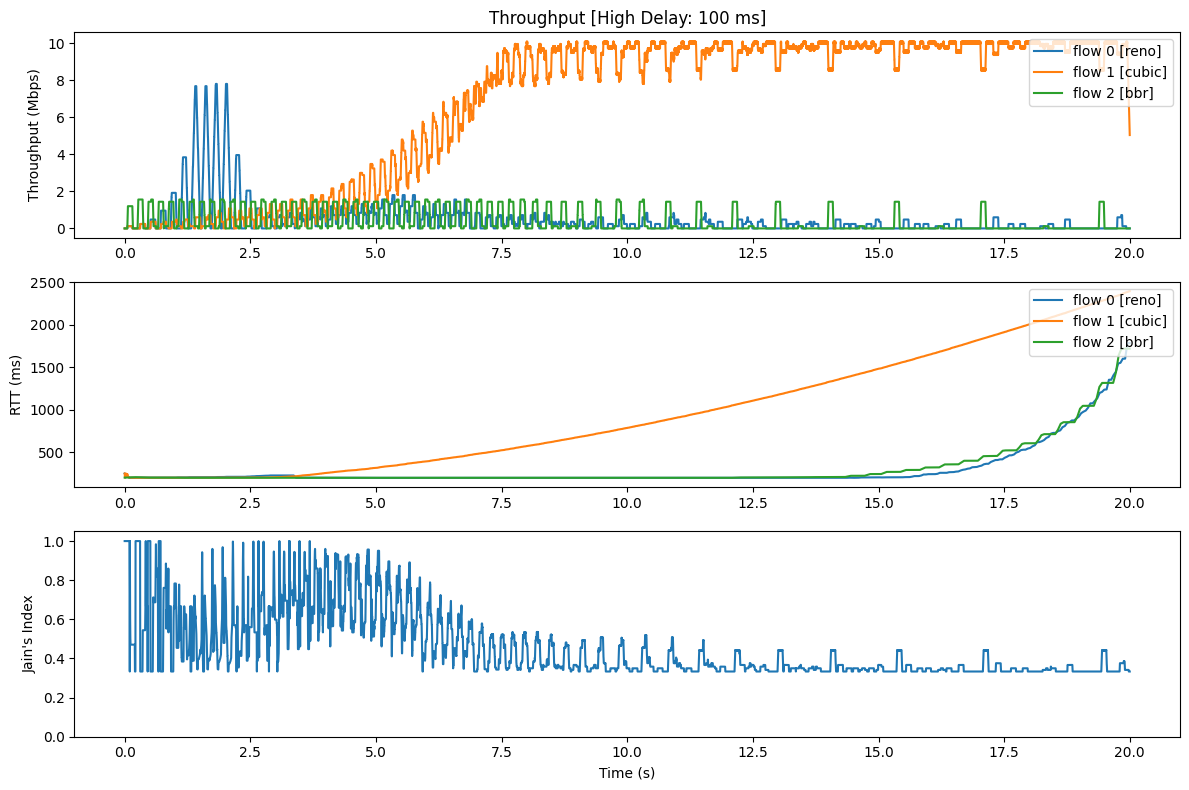

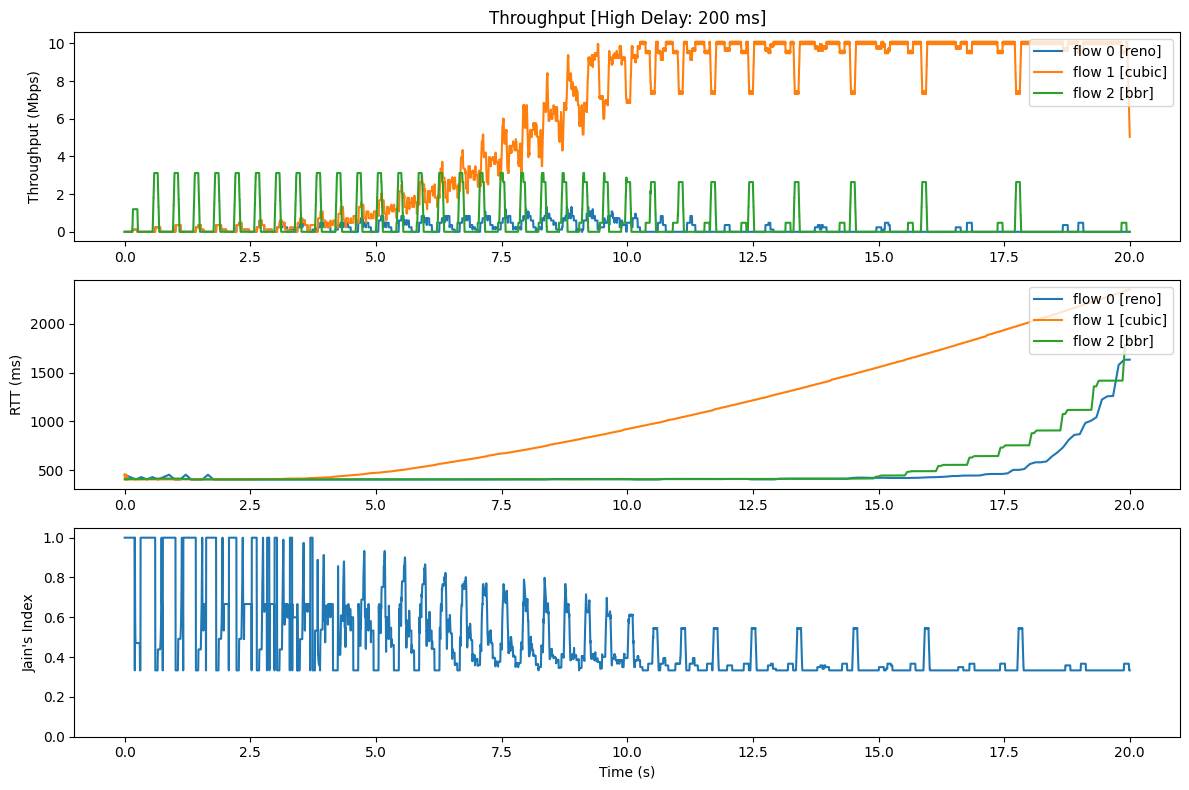

In [4]:

def scenario_high_delay(delay):
    return run_experiment(['reno','cubic','bbr'], capacity_mbps=10, prop_ms=delay, buffer_pkts=200,
                          use_codel=False, ge_fwd=GilbertElliott(0,0,0,1), ge_rev=GilbertElliott(0,0,0,1))

for d in [100, 200]:
    sim = scenario_high_delay(d)
    _ = plot_results(sim, title_suffix=f'[High Delay: {d} ms]')
    df, jain = summarize(sim, f'High Delay {d} ms')
    print(to_pretty_table(df, title=f'High Delay {d} ms Summary'))
    print(f"Jain index (mean over time): {jain:.3f}")



**Explanation of outputs**  
- Reno’s cwnd growth is RTT-limited; its throughput increases slowly with large BDP.  
- CUBIC and BBR retain higher goodput at larger delays.  
- Baseline RTT rises by the configured propagation delay; queuing adds on top if the buffer fills.



## 4) Bandwidth Scaling

**Config**  
- Delay: 20 ms, Loss: 0%  
- Bandwidth: 2, 5, 10, 50 Mbps

**Purpose**  
See scalability with capacity.


+--------------------------------------------------------------------------------+
|                            Bandwidth 2 Mbps Summary                            |
+------------------+------+-------+---------------------+------------+-----------+
|     scenario     | flow |  algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+------------------+------+-------+---------------------+------------+-----------+
| Bandwidth 2 Mbps |  0   |  reno |        0.287        |  476.425   |     0     |
| Bandwidth 2 Mbps |  1   | cubic |        1.625        |  2466.859  |     0     |
| Bandwidth 2 Mbps |  2   |  bbr  |        0.082        |  404.500   |     0     |
+------------------+------+-------+---------------------+------------+-----------+
Jain index (mean over time): 0.463
+--------------------------------------------------------------------------------+
|                            Bandwidth 5 Mbps Summary                            |
+------------------+------+-------+-----------------

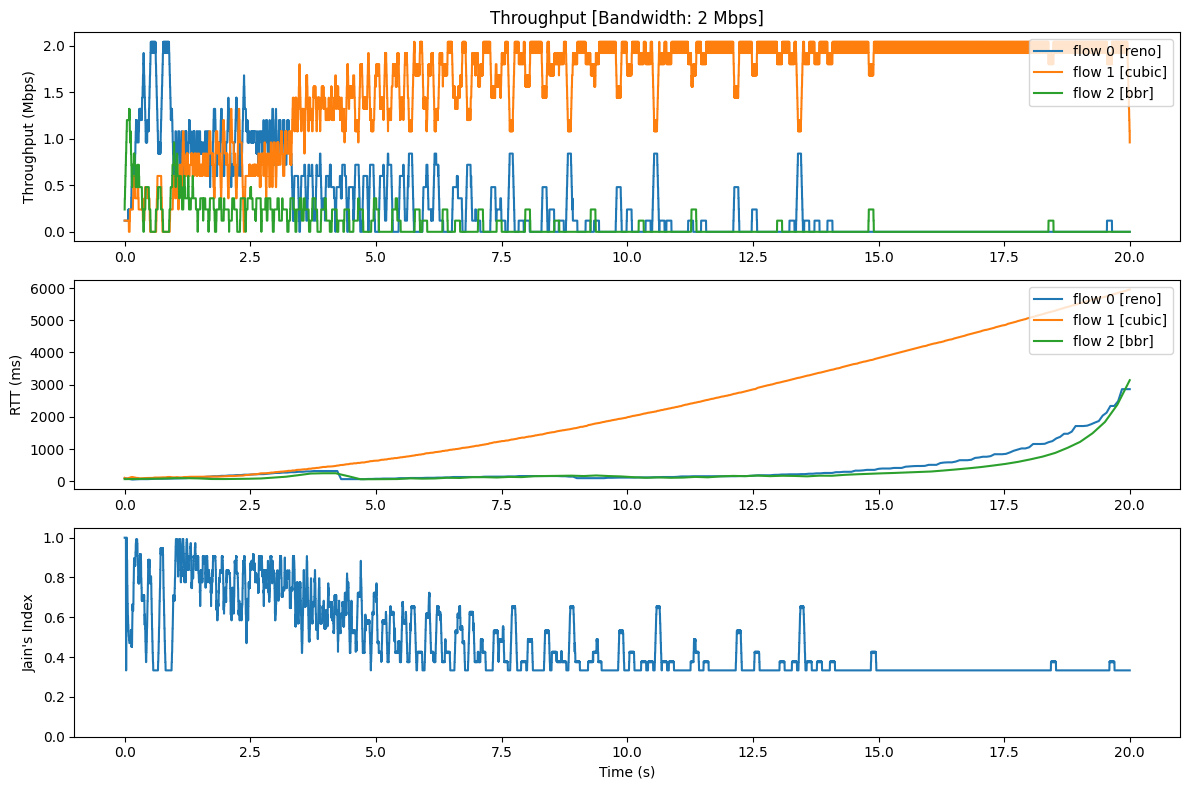

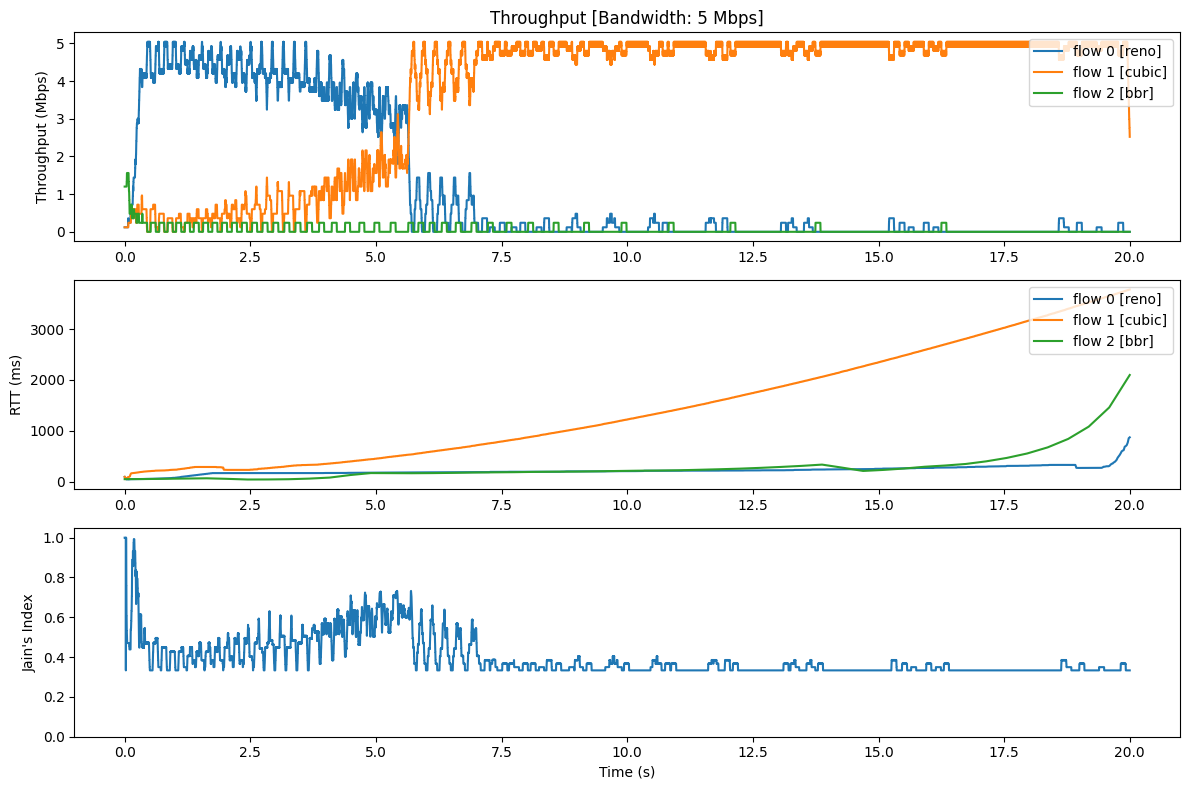

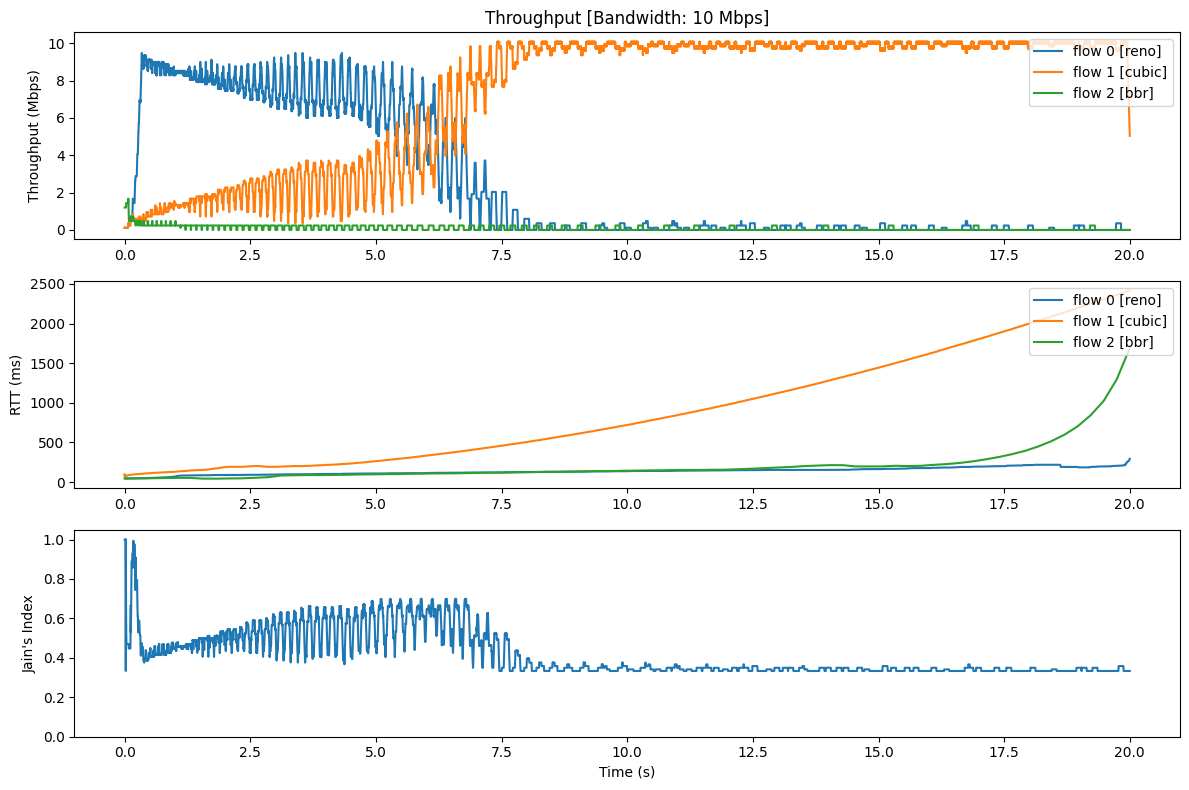

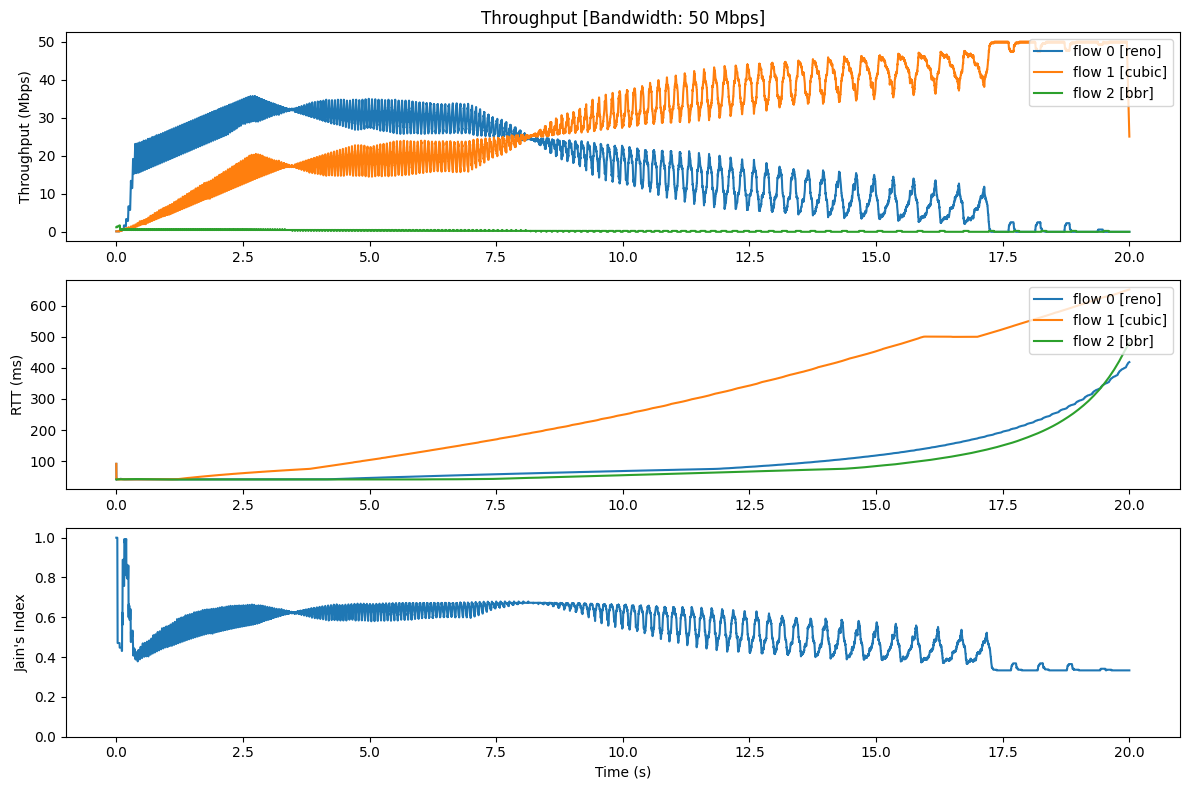

In [5]:

def scenario_bandwidth(capacity):
    return run_experiment(['reno','cubic','bbr'], capacity_mbps=capacity, prop_ms=20, buffer_pkts=200,
                          use_codel=False, ge_fwd=GilbertElliott(0,0,0,1), ge_rev=GilbertElliott(0,0,0,1))

for bw in [2, 5, 10, 50]:
    sim = scenario_bandwidth(bw)
    _ = plot_results(sim, title_suffix=f'[Bandwidth: {bw} Mbps]')
    df, jain = summarize(sim, f'Bandwidth {bw} Mbps')
    print(to_pretty_table(df, title=f'Bandwidth {bw} Mbps Summary'))
    print(f"Jain index (mean over time): {jain:.3f}")



**Explanation of outputs**  
- Aggregate throughput increases with capacity; per-flow shares depend on the algorithms’ dynamics.  
- BBR tends to stabilize quickly; Reno grows more slowly; CUBIC ramps faster than Reno.  
- With large buffers, RTT can still inflate; AQM or smaller buffers reduce this.



## 5) Competing Flows (Fairness Tests)

**Config**  
- Bandwidth: 10 Mbps, Delay: 50 ms, Loss: 0%  
- Pairs: Reno vs Reno, Reno vs CUBIC, CUBIC vs BBR, Reno vs BBR  
- The second flow starts at 500 ms (late-comer).

**Purpose**  
Compare fairness and late-comer effects.


+------------------------------------------------------------------------------------+
|                           Fairness reno vs reno Summary                            |
+-----------------------+------+------+---------------------+------------+-----------+
|        scenario       | flow | algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+-----------------------+------+------+---------------------+------------+-----------+
| Fairness reno vs reno |  0   | reno |        1.874        |  135.019   |     0     |
| Fairness reno vs reno |  1   | reno |        7.559        |  143.869   |     0     |
+-----------------------+------+------+---------------------+------------+-----------+
Jain index (mean over time): 0.699
+--------------------------------------------------------------------------------------+
|                            Fairness reno vs cubic Summary                            |
+------------------------+------+-------+---------------------+------------+-----------+
| 

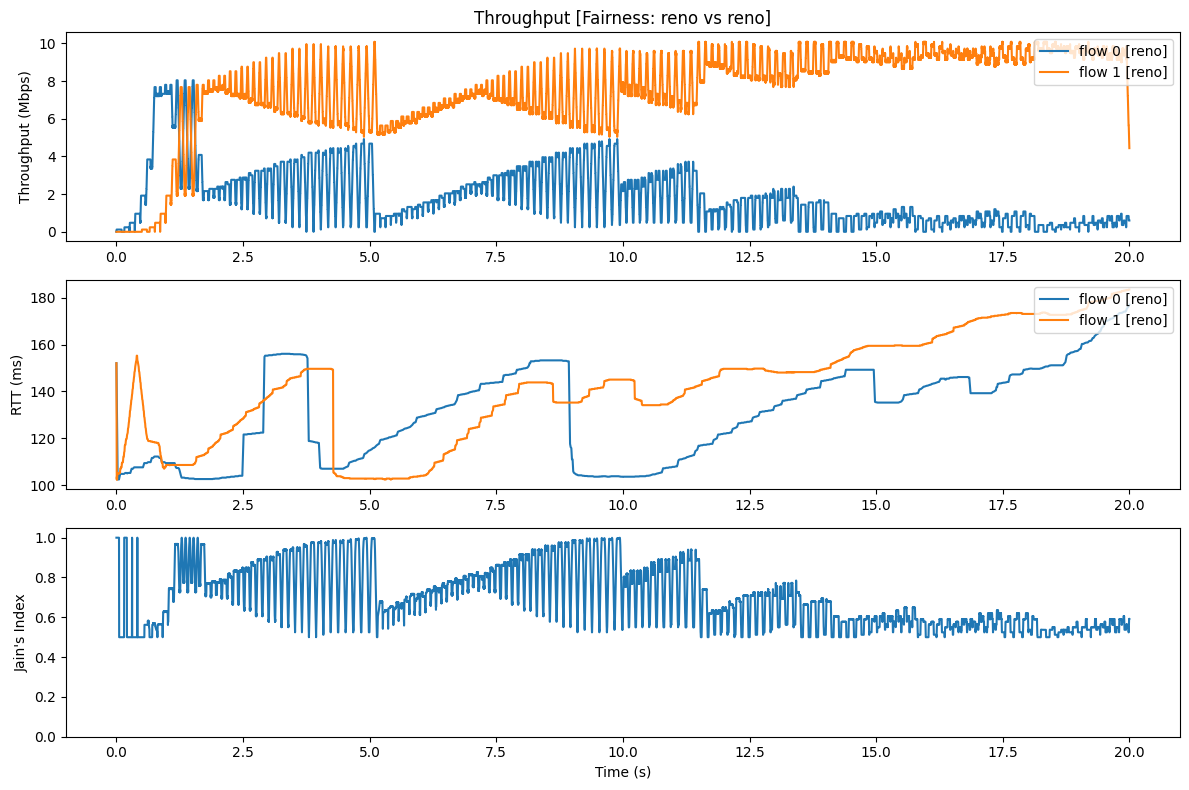

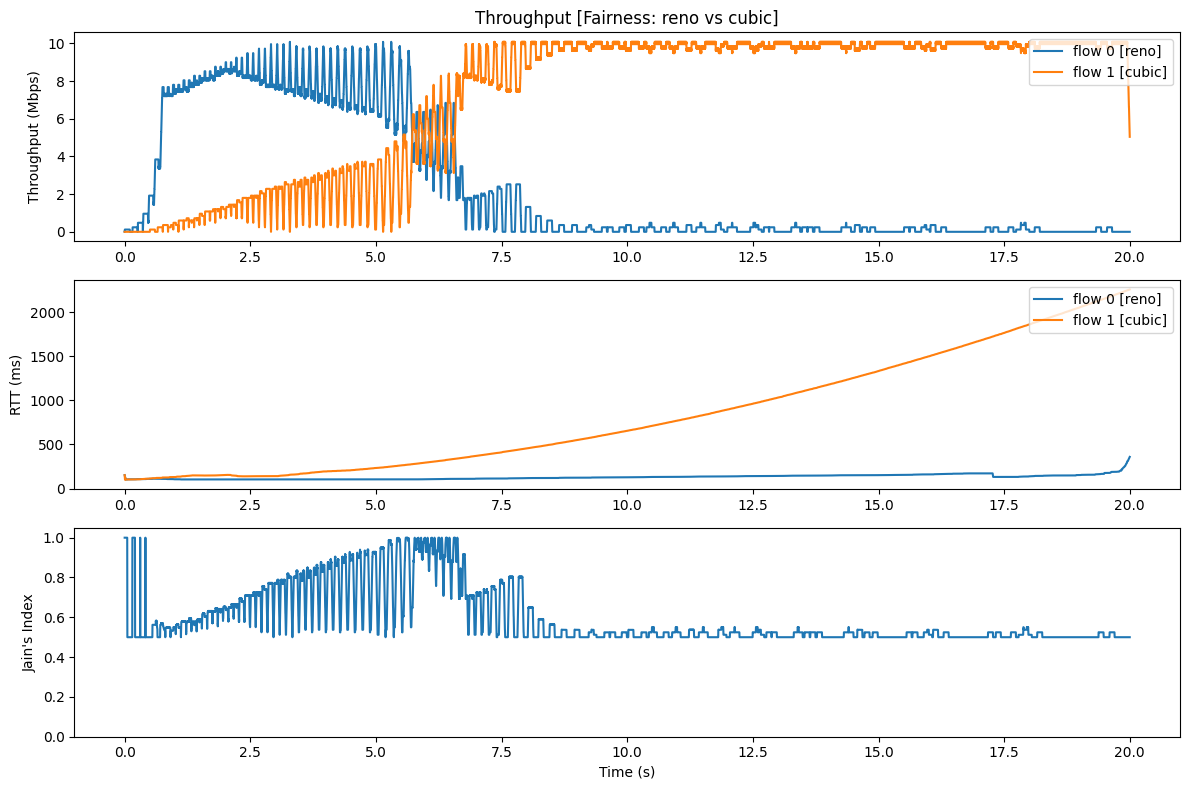

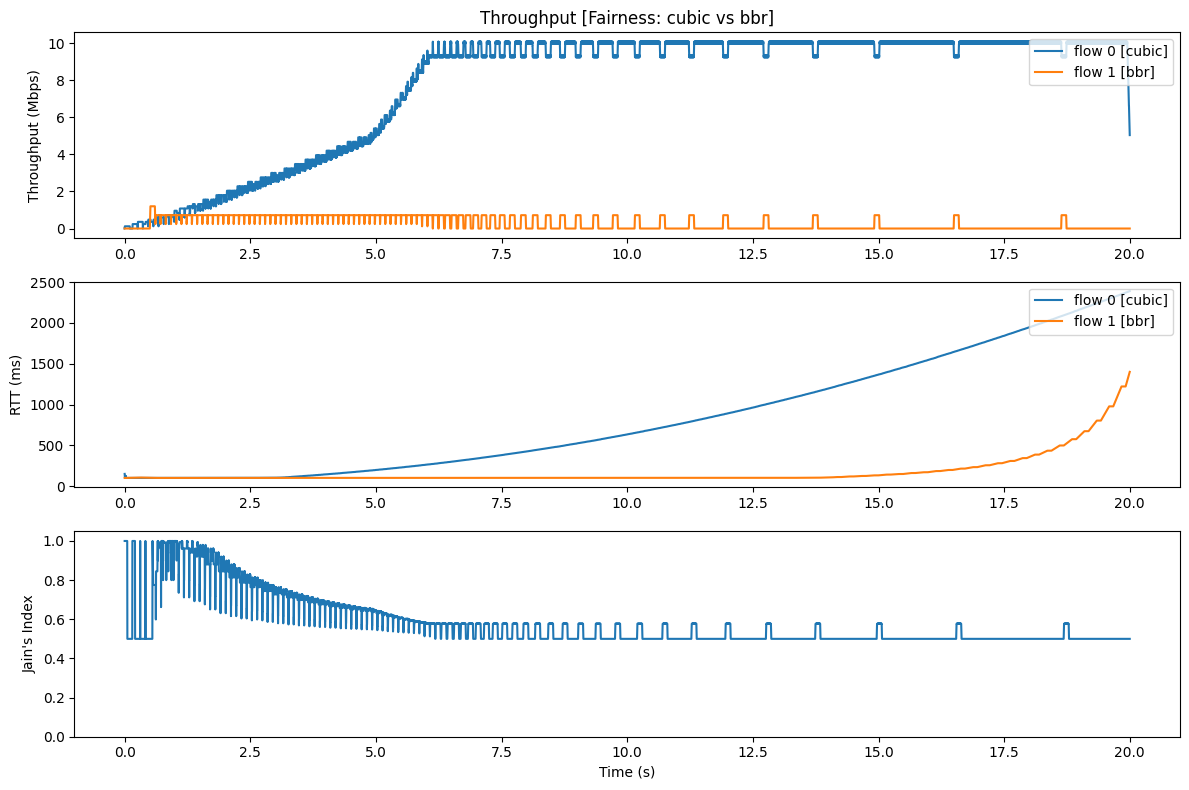

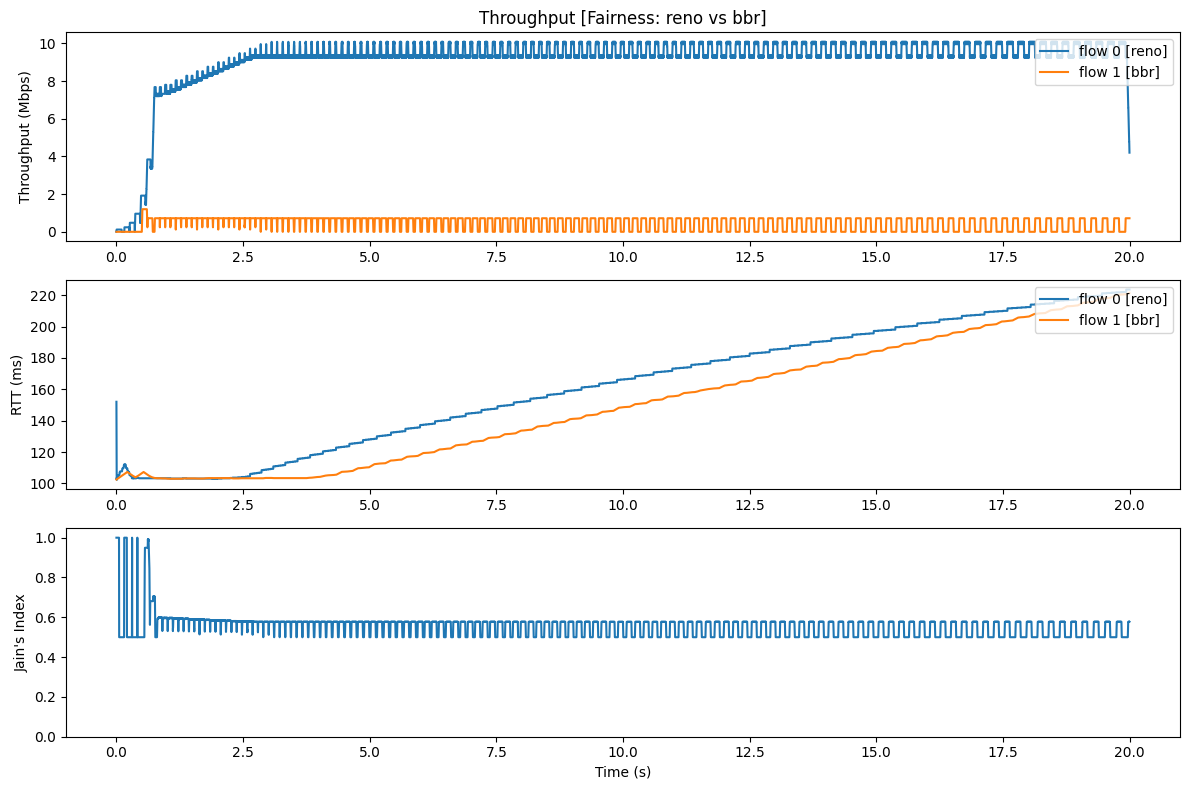

In [6]:

def scenario_fairness(algos):
    return run_experiment(algos, capacity_mbps=10, prop_ms=50, buffer_pkts=200,
                          use_codel=False, ge_fwd=GilbertElliott(0,0,0,1), ge_rev=GilbertElliott(0,0,0,1),
                          start_stagger_ms=500)

pairs = [
    ['reno','reno'],
    ['reno','cubic'],
    ['cubic','bbr'],
    ['reno','bbr']
]

for pair in pairs:
    sim = scenario_fairness(pair)
    _ = plot_results(sim, title_suffix=f'[Fairness: {pair[0]} vs {pair[1]}]')
    df, jain = summarize(sim, f'Fairness {pair[0]} vs {pair[1]}')
    print(to_pretty_table(df, title=f'Fairness {pair[0]} vs {pair[1]} Summary'))
    print(f"Jain index (mean over time): {jain:.3f}")



**Explanation of outputs**  
- Reno vs Reno tends to be fair (Jain close to 1).  
- Reno vs CUBIC usually favors CUBIC; CUBIC vs BBR shows different queue/RTT behavior but often comparable goodput.  
- Reno vs BBR highlights Reno’s sensitivity to delay and loss vs BBR’s pacing.



## 6) Wireless-like Conditions

**Config**  
- Bandwidth: 10 Mbps, Delay: 50 ms  
- Forward path: ~1% bursty loss (GE model)  
- CoDel AQM enabled, larger buffer

**Purpose**  
Emulate random wireless loss where drops are not congestion-driven.


+-----------------------------------------------------------------------------+
|                            Wireless-like Summary                            |
+---------------+------+-------+---------------------+------------+-----------+
|    scenario   | flow |  algo | avg_throughput_mbps | avg_rtt_ms | lost_pkts |
+---------------+------+-------+---------------------+------------+-----------+
| Wireless-like |  0   |  reno |        1.036        |  127.570   |     16    |
| Wireless-like |  1   | cubic |        6.550        |  127.906   |    100    |
| Wireless-like |  2   |  bbr  |        0.568        |  123.494   |     7     |
+---------------+------+-------+---------------------+------------+-----------+
Jain index (mean over time): 0.546


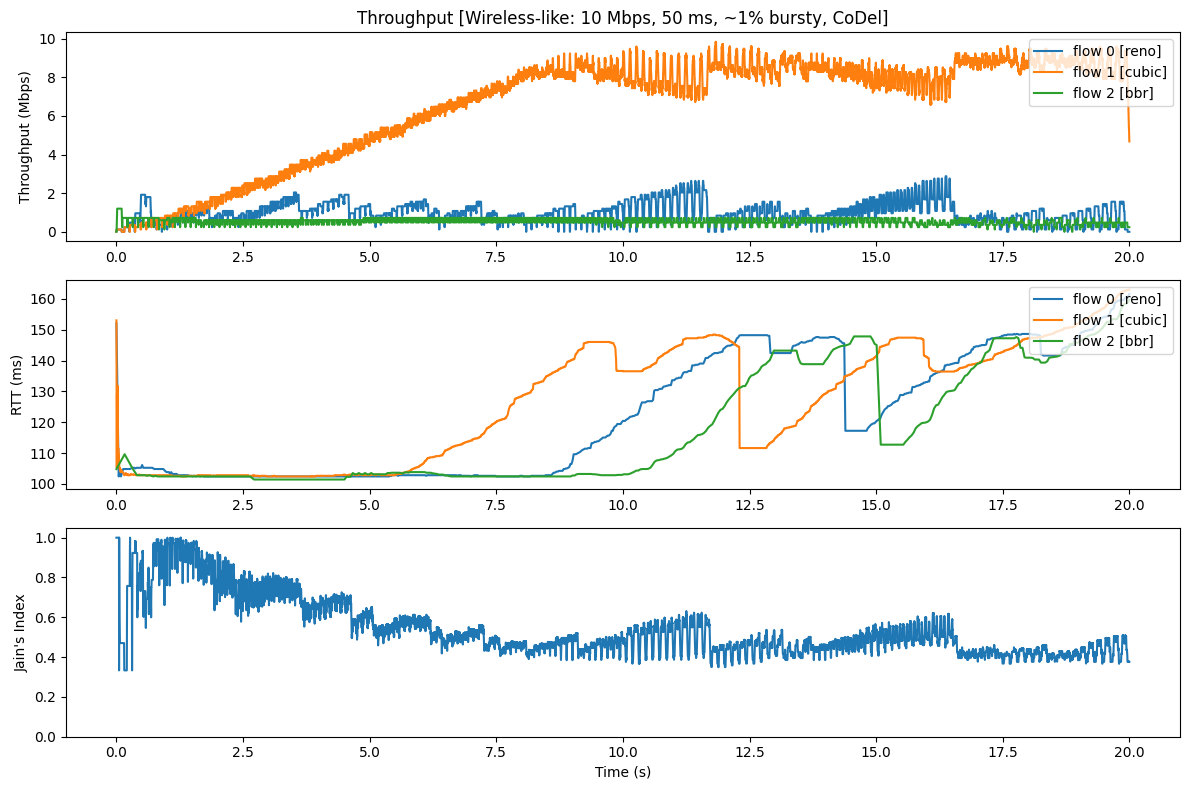

In [7]:

def scenario_wireless():
    g = GilbertElliott(loss_g=0.004, loss_b=0.05, p_gb=0.01, p_bg=0.1)
    return run_experiment(['reno','cubic','bbr'], capacity_mbps=10, prop_ms=50, buffer_pkts=400,
                          use_codel=True, ge_fwd=g, ge_rev=GilbertElliott(0,0,0,1))

sim = scenario_wireless()
_ = plot_results(sim, title_suffix='[Wireless-like: 10 Mbps, 50 ms, ~1% bursty, CoDel]')
df, jain = summarize(sim, "Wireless-like")
print(to_pretty_table(df, title="Wireless-like Summary"))
print(f"Jain index (mean over time): {jain:.3f}")



**Explanation of outputs**  
- BBR tends to maintain throughput with moderate RTT under random loss; Reno suffers; CUBIC without AQM would inflate queues, but CoDel confines latency.  
- Use the table to compare average Mbps; the plot’s y-axis uses the same units, verified by the per-scenario accounting.


In [11]:
# === Master Summary (all scenarios) ===
# Requires the scenario_* functions and summarize(), to_pretty_table()
# that are already defined earlier in the notebook.

from copy import deepcopy

def _meta_row(df, meta: dict):
    """Attach scenario metadata to each row of a summary DataFrame."""
    df2 = df.copy()
    for k, v in meta.items():
        df2[k] = v
    return df2

def run_all_scenarios_summary():
    all_rows = []

    # 1) Baseline
    sim = scenario_baseline()
    df, jain = summarize(sim, "Baseline")
    meta = dict(scenario_type="Baseline", capacity_mbps=10, delay_ms=20, loss_pct=0.0, aqm="off", jain_mean=jain)
    all_rows.append(_meta_row(df, meta))

    # 2) Loss sensitivity
    for p in [0.005, 0.01, 0.02]:
        sim = scenario_loss(p)
        df, jain = summarize(sim, f"Loss {p*100:.1f}%")
        meta = dict(scenario_type="Loss", capacity_mbps=10, delay_ms=20, loss_pct=100*p, aqm="off", jain_mean=jain)
        all_rows.append(_meta_row(df, meta))

    # 3) High Delay
    for d in [100, 200]:
        sim = scenario_high_delay(d)
        df, jain = summarize(sim, f"High Delay {d} ms")
        meta = dict(scenario_type="HighDelay", capacity_mbps=10, delay_ms=d, loss_pct=0.0, aqm="off", jain_mean=jain)
        all_rows.append(_meta_row(df, meta))

    # 4) Bandwidth scaling
    for bw in [2, 5, 10, 50]:
        sim = scenario_bandwidth(bw)
        df, jain = summarize(sim, f"Bandwidth {bw} Mbps")
        meta = dict(scenario_type="Bandwidth", capacity_mbps=bw, delay_ms=20, loss_pct=0.0, aqm="off", jain_mean=jain)
        all_rows.append(_meta_row(df, meta))

    # 5) Fairness tests
    pairs = [
        ['reno','reno'],
        ['reno','cubic'],
        ['cubic','bbr'],
        ['reno','bbr']
    ]
    for pair in pairs:
        sim = scenario_fairness(pair)
        df, jain = summarize(sim, f'Fairness {pair[0]} vs {pair[1]}')
        meta = dict(scenario_type="Fairness", pair=f"{pair[0]} vs {pair[1]}",
                    capacity_mbps=10, delay_ms=50, loss_pct=0.0, aqm="off", jain_mean=jain)
        all_rows.append(_meta_row(df, meta))

    # 6) Wireless-like
    sim = scenario_wireless()
    df, jain = summarize(sim, "Wireless-like")
    # Approximate loss level for the label; GE params are bursty. Use ~1%.
    meta = dict(scenario_type="Wireless", capacity_mbps=10, delay_ms=50, loss_pct=1.0, aqm="CoDel", jain_mean=jain)
    all_rows.append(_meta_row(df, meta))

    df_all = pd.concat(all_rows, ignore_index=True)

    # Reorder columns for readability
    front_cols = ["scenario", "scenario_type", "flow", "algo",
                  "capacity_mbps", "delay_ms", "loss_pct", "aqm",
                  "avg_throughput_mbps", "avg_rtt_ms", "lost_pkts", "jain_mean"]
    cols = [c for c in front_cols if c in df_all.columns] + [c for c in df_all.columns if c not in front_cols]
    df_all = df_all[cols]

    # PrettyTable print (compact)
    # If the table is long, you can filter or round more aggressively.
    pt = PrettyTable()
    pt.title = "All Scenarios — Summary"
    pt.field_names = ["scenario", "flow", "algo", "capacity_mbps", "delay_ms", "loss_pct",
                      "avg_throughput_mbps", "avg_rtt_ms", "lost_pkts", "jain_mean", "scenario_type", "aqm"]
    for _, r in df_all.iterrows():
        pt.add_row([
            r["scenario"], int(r["flow"]), r["algo"],
            f"{float(r['capacity_mbps']):.0f}", f"{float(r['delay_ms']):.0f}", f"{float(r['loss_pct']):.1f}",
            f"{float(r['avg_throughput_mbps']):.3f}",
            f"{float(r['avg_rtt_ms']):.1f}" if pd.notna(r["avg_rtt_ms"]) else "nan",
            int(r["lost_pkts"]), f"{float(r['jain_mean']):.3f}", r["scenario_type"], r["aqm"]
        ])
    print(pt)

    # Also keep as a DataFrame for further analysis/plotting

    # Optional: save to CSV in case you need a file
    # df_all.to_csv("tcp_cc_all_scenarios_summary.csv", index=False)

    return df_all

df_all = run_all_scenarios_summary()


+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                    All Scenarios — Summary                                                                     |
+------------------------+------+-------+---------------+----------+----------+---------------------+------------+-----------+-----------+---------------+-------+
|        scenario        | flow |  algo | capacity_mbps | delay_ms | loss_pct | avg_throughput_mbps | avg_rtt_ms | lost_pkts | jain_mean | scenario_type |  aqm  |
+------------------------+------+-------+---------------+----------+----------+---------------------+------------+-----------+-----------+---------------+-------+
|        Baseline        |  0   |  reno |       10      |    20    |   0.0    |        2.465        |   161.7    |     0     |   0.416   |    Baseline   |  off  |
|        Baseline     